In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
import pandas as pd
import numpy as np
# Import libraries for LSTM
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

import warnings
warnings.filterwarnings("ignore")

# Load and Prepare the Data

In [24]:
# Import data
df = pd.read_csv('cleaned_data.csv', parse_dates=['Date'], index_col='Date')

target = df['ManU_stock']

df

,ManU_stock,Lindsell_stock,Position,Points,Cumulative_points,Unexpected_points,Interest
Date,,,,,,,
2016-08-15,16.570000,783.5,1.0,3.0,3.0,1.080851,38.0
2016-08-16,16.440001,785.0,1.0,3.0,3.0,1.080851,38.0
2016-08-17,16.260000,785.0,1.0,3.0,3.0,1.080851,38.0
2016-08-18,16.580000,805.0,1.0,3.0,3.0,1.080851,38.0
2016-08-19,16.350000,819.0,1.0,3.0,6.0,0.852684,38.0
...,...,...,...,...,...,...,...
2024-05-13,16.030001,788.0,8.0,0.0,54.0,-0.433055,43.0
2024-05-14,16.129999,800.0,8.0,0.0,54.0,-0.433055,43.0
2024-05-15,16.850000,806.0,8.0,3.0,57.0,1.681051,43.0


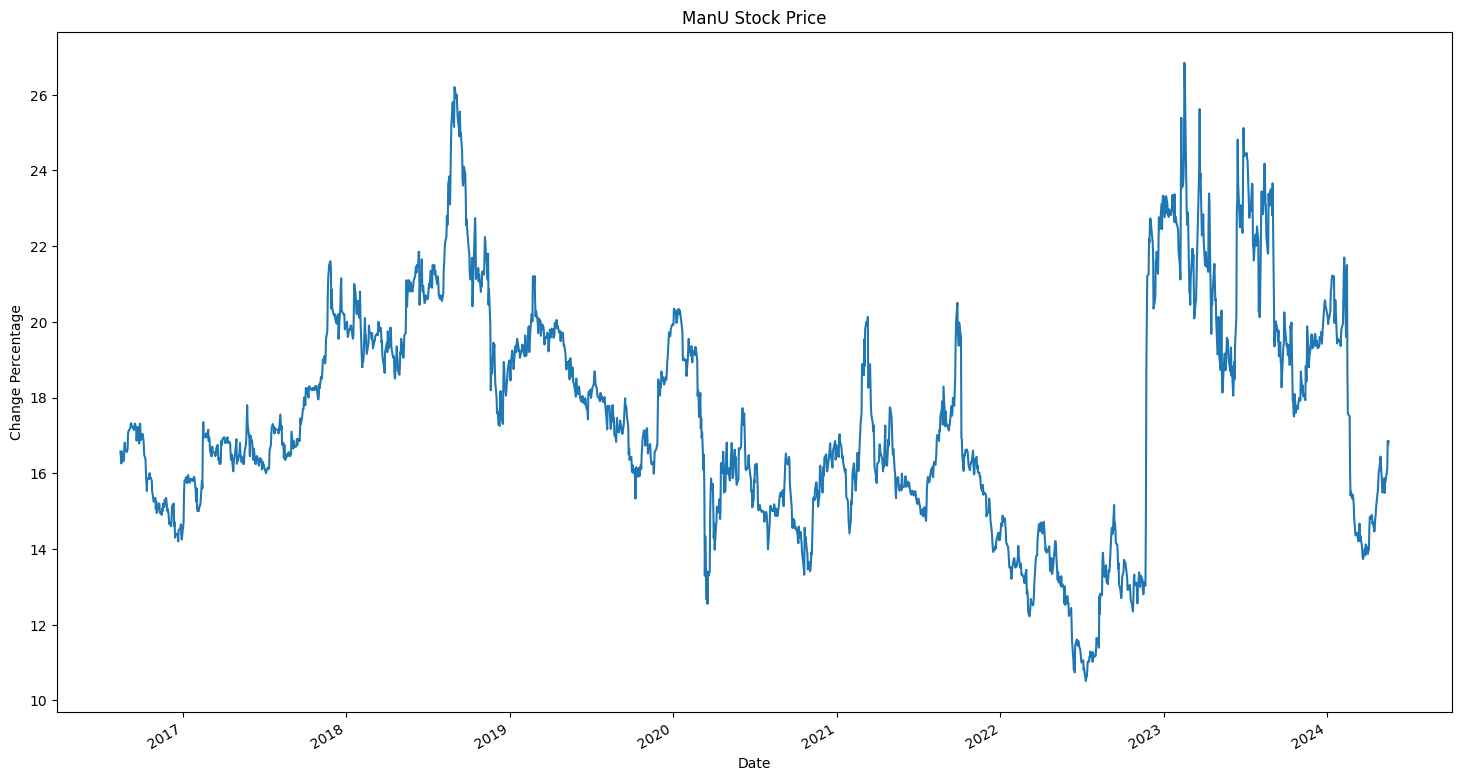

In [25]:
fig, ax = plt.subplots(figsize=(18, 10))
target.plot()
plt.title('ManU Stock Price')
plt.xlabel('Date')
plt.ylabel('Change Percentage')
plt.show()

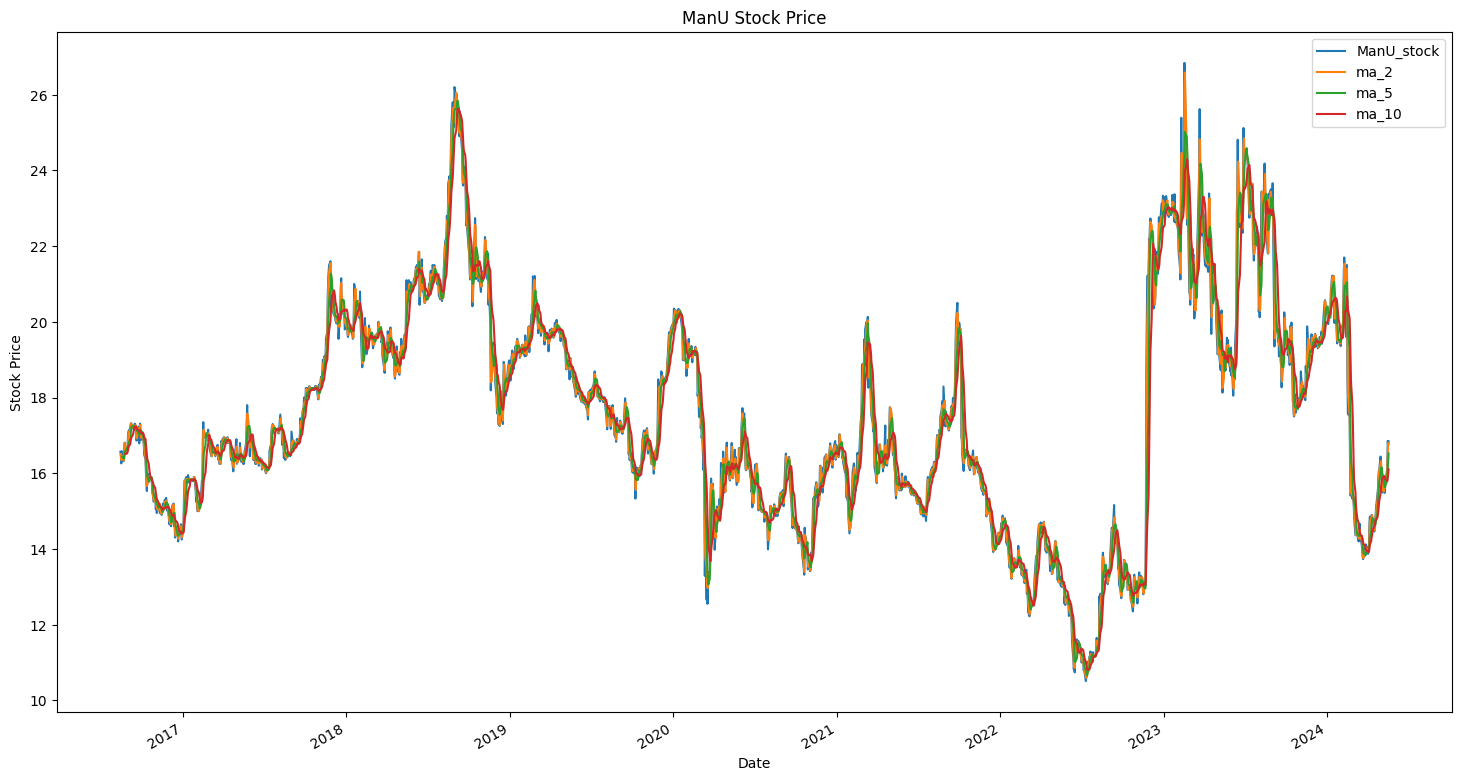

In [26]:
# moving averages for 5 days, 30 days, 365 days
df['ma_2'] = df['ManU_stock'].rolling(window=2).mean()
df['ma_5'] = df['ManU_stock'].rolling(window=5).mean()
df['ma_10'] = df['ManU_stock'].rolling(window=10).mean()

fig, ax = plt.subplots(figsize=(18, 10))
df['ManU_stock'].plot(title='ManU Stock Price')
df['ma_2'].plot(title='2 Days Moving Average')
df['ma_5'].plot(title='5 Days Moving Average')
df['ma_10'].plot(title='10 Days Moving Average')
plt.title('ManU Stock Price')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

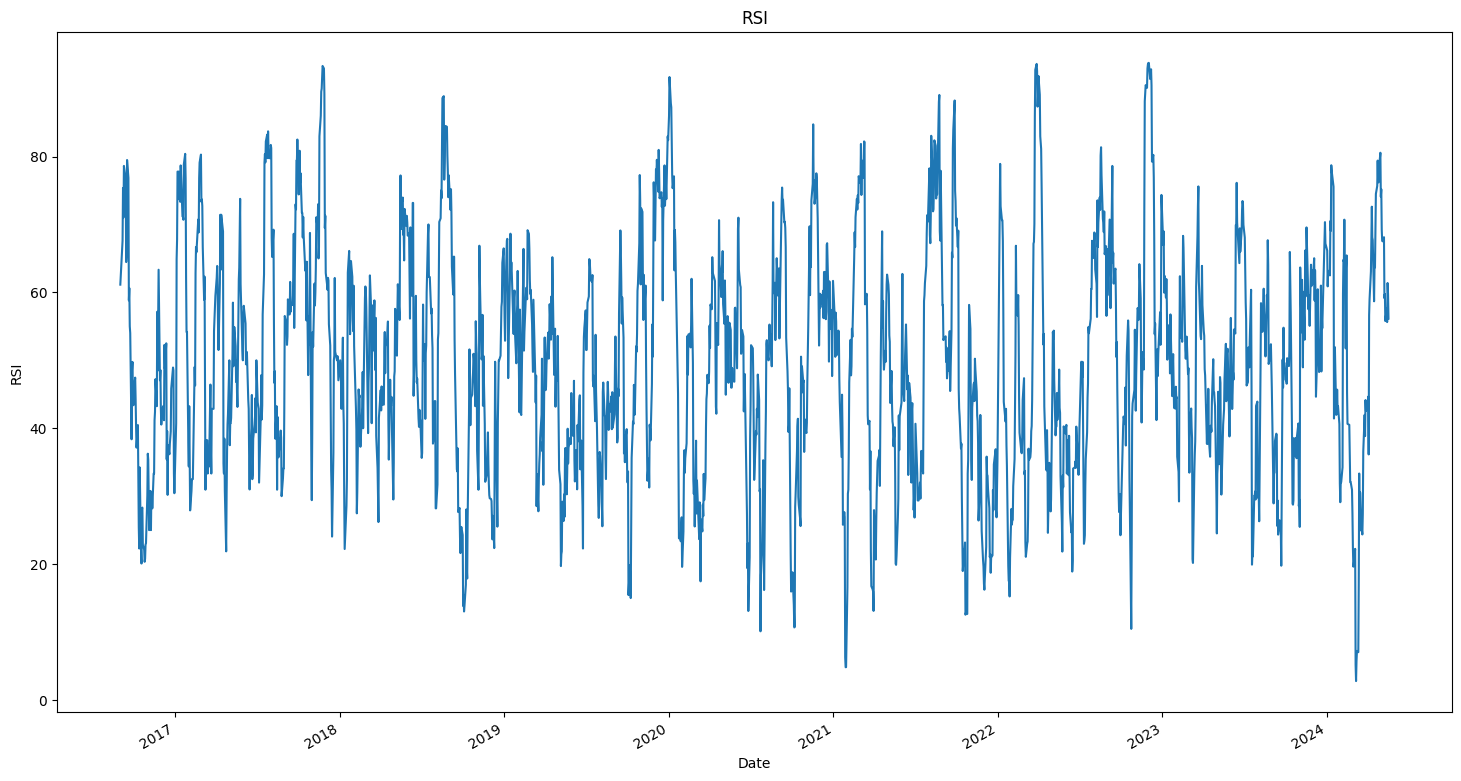

In [28]:
# relative strength index (RSI)
def RSI(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

df['RSI'] = RSI(df['ManU_stock'])

fig, ax = plt.subplots(figsize=(18, 10))
df['RSI'].plot()
plt.title('RSI')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.show()

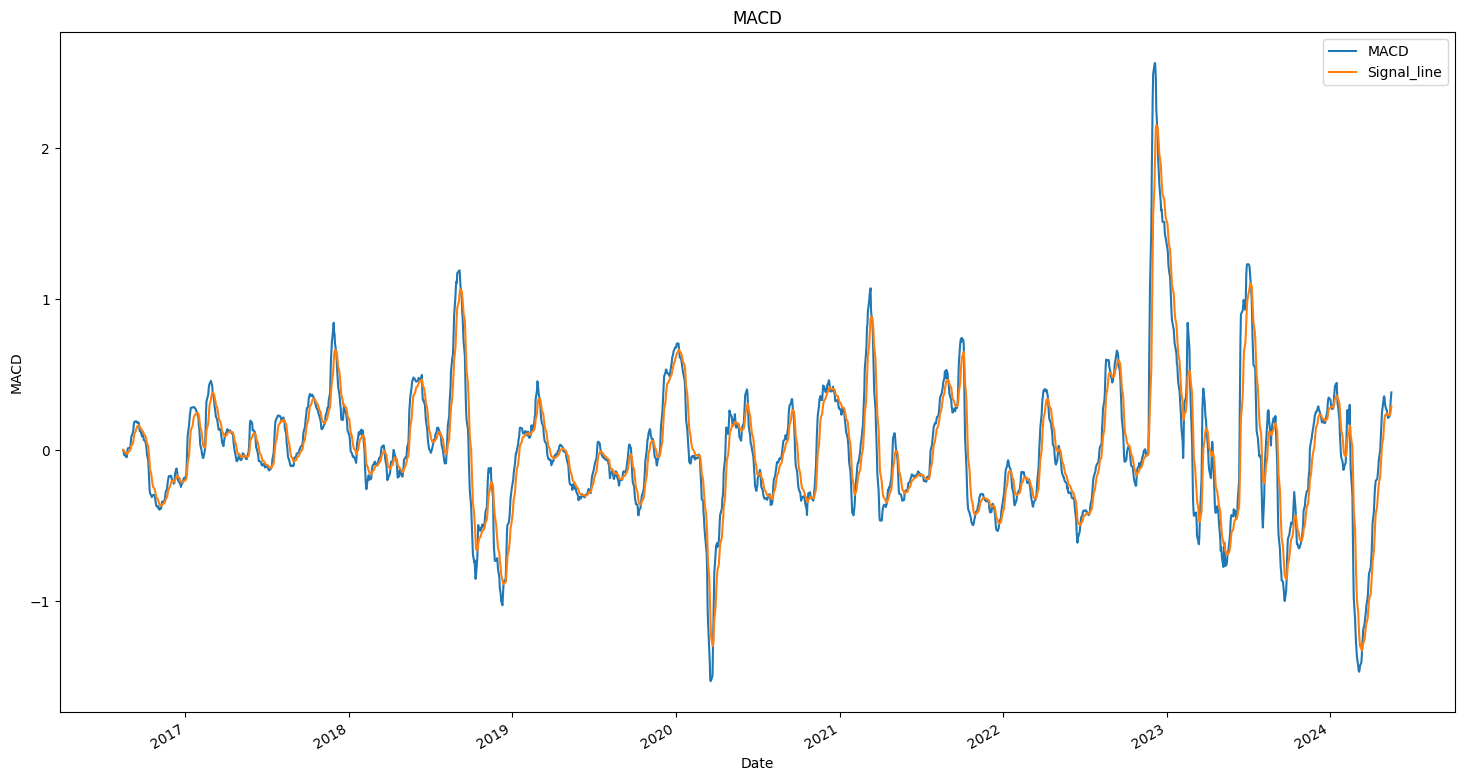

In [29]:
# moving average convergence divergence (MACD)
def MACD(series, short=12, long=26, signal=9):
    short_ema = series.ewm(span=short, adjust=False).mean()
    long_ema = series.ewm(span=long, adjust=False).mean()
    macd = short_ema - long_ema
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    return macd, signal_line

df['MACD'], df['Signal_line'] = MACD(df['ManU_stock'])

fig, ax = plt.subplots(figsize=(18, 10))
df['MACD'].plot()
df['Signal_line'].plot()
plt.title('MACD')
plt.xlabel('Date')
plt.ylabel('MACD')
plt.legend()
plt.show()

In [30]:
# shift the target variable by 1 - so the model can predict the next day's stock price
df['ManU_stock'] = df['ManU_stock'].shift(-1)
df = df.dropna()
train_size = int(0.8 * len(df))

In [31]:
def create_train_test(features_list):
    # split the data into train and test
    X = df[features_list]
    y = df['ManU_stock']

    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # normalize the data
    features_scaler = StandardScaler().fit(X_train)
    target_scaler = StandardScaler().fit(y_train.values.reshape(-1, 1))

    X_train = features_scaler.transform(X_train)
    X_test = features_scaler.transform(X_test)
    y_train = target_scaler.transform(y_train.values.reshape(-1, 1))
    y_test = target_scaler.transform(y_test.values.reshape(-1, 1))

    X_train = pd.DataFrame(X_train, columns=X.columns, index=df.index[:train_size])
    X_test = pd.DataFrame(X_test, columns=X.columns, index=df.index[train_size:])
    y_train = pd.Series(y_train.flatten(), index=df.index[:train_size])
    y_test = pd.Series(y_test.flatten(), index=df.index[train_size:])

    return X_train, X_test, y_train, y_test, target_scaler

In [32]:
# xgb regressor
def train_and_forecast_XGB(X_train, y_train, X_test, y_test, target_scaler):
    xgb_reg = xgb.XGBRegressor(objective='reg:squarederror')
    xgb_reg.fit(X_train, y_train)

    y_pred = xgb_reg.predict(X_test)
    y_pred = target_scaler.inverse_transform(y_pred.reshape(-1, 1))
    y_test = target_scaler.inverse_transform(y_test.values.reshape(-1, 1))
    y_train = target_scaler.inverse_transform(y_train.values.reshape(-1, 1))

    # save results with date
    xgb_results = pd.DataFrame({'Date': df.index[train_size:], 'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})

    print('XGBoost Regressor')
    print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', mean_squared_error(y_test, y_pred))

    # plot the predictions
    fig, ax = plt.subplots(figsize=(18, 8))
    plt.plot(xgb_results['Date'], xgb_results['Actual'], color='blue')
    plt.plot(xgb_results['Date'], xgb_results['Predicted'], color='red')
    plt.plot(X_train.index, y_train, color='green')
    plt.title('XGBoost Regressor')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend(['Actual', 'Predicted', 'Train'])
    plt.show()

    # plot feature importance
    fig, ax = plt.subplots(figsize=(18, 8))
    xgb.plot_importance(xgb_reg, ax=ax)
    plt.title('Feature Importance')
    plt.show()

    return xgb_results

XGBoost Regressor
Mean Absolute Error: 0.9569899519694222
Mean Squared Error: 1.7861114629055512


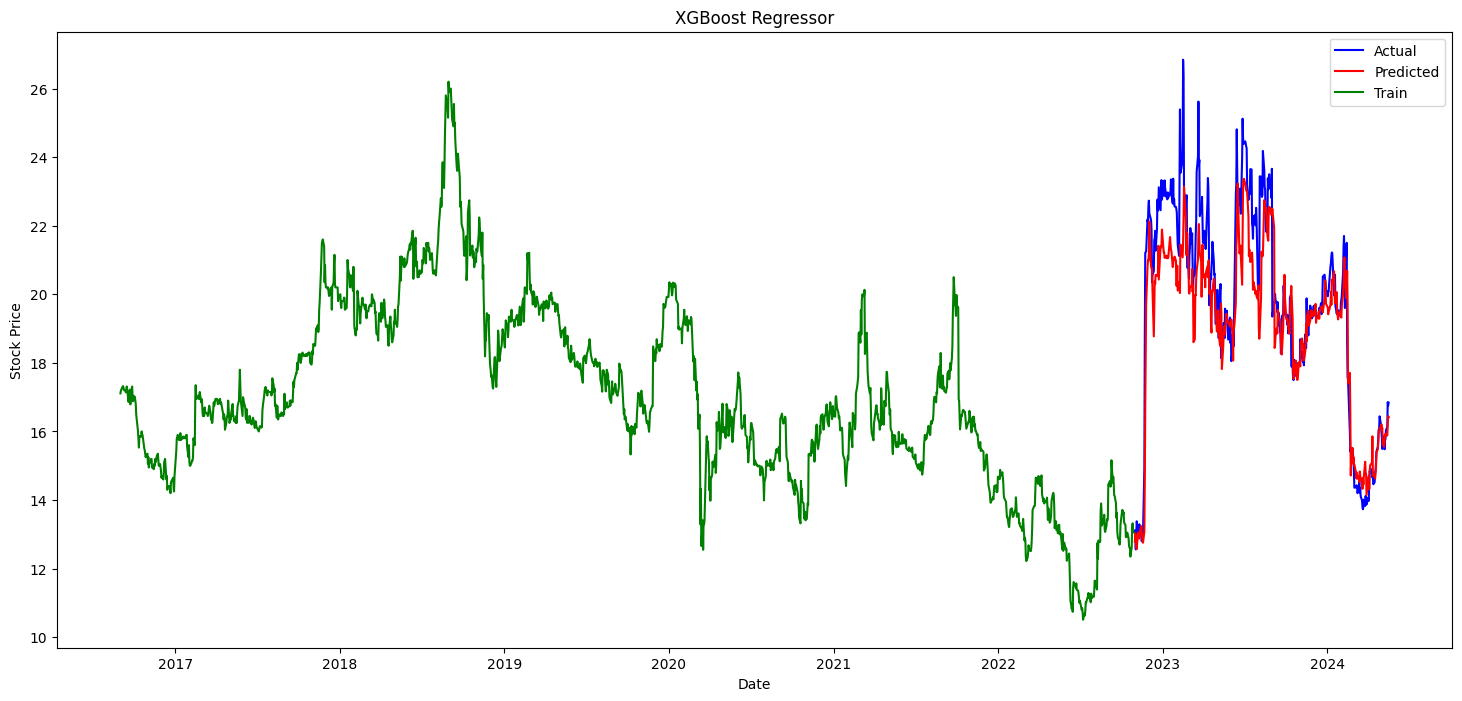

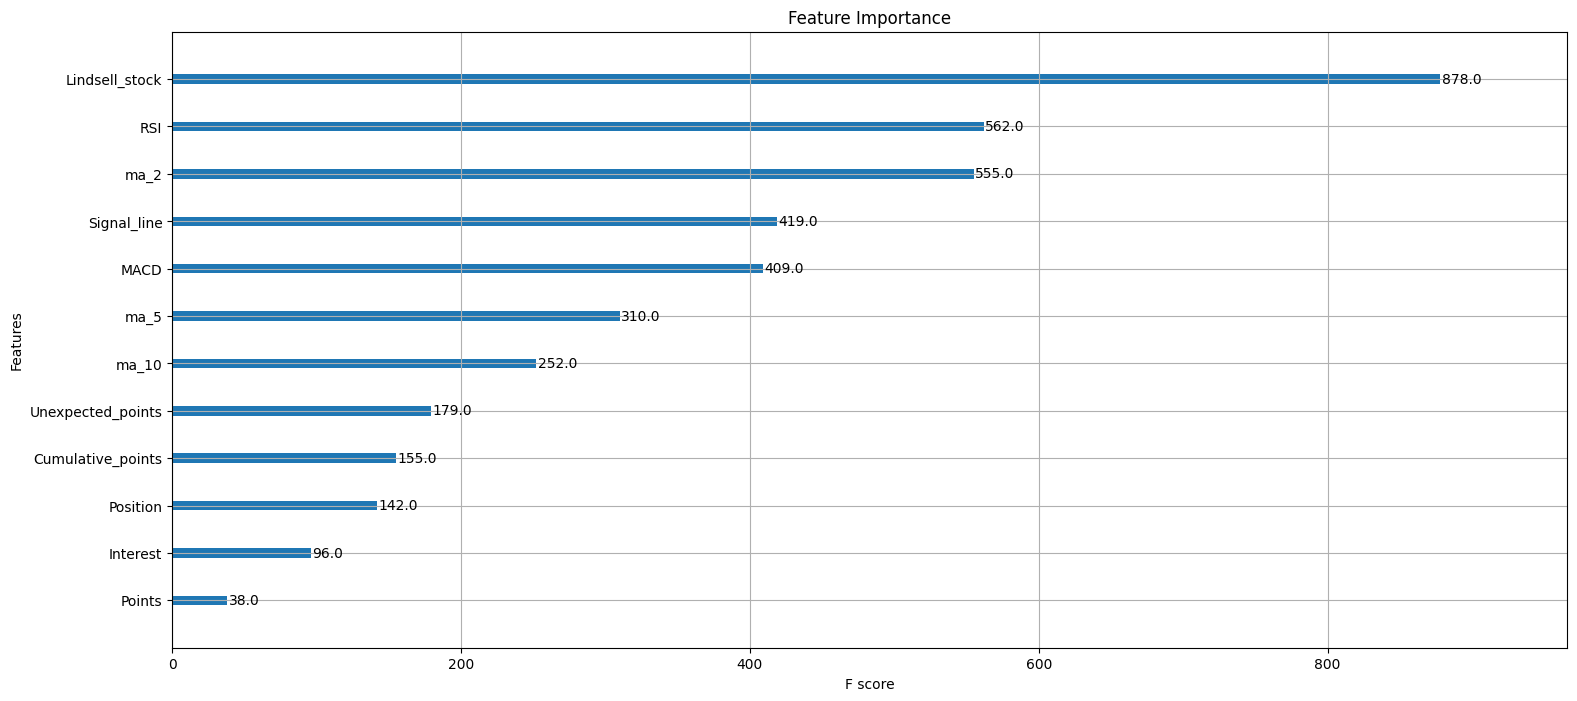

In [33]:
features = df.columns
# drop the target variable
features = features.drop('ManU_stock')
X_train, X_test, y_train, y_test, target_scaler = create_train_test(features)
xgb_results = train_and_forecast_XGB(X_train, y_train, X_test, y_test, target_scaler)

XGBoost Regressor
Mean Absolute Error: 0.7773273261552004
Mean Squared Error: 1.2627607452419476


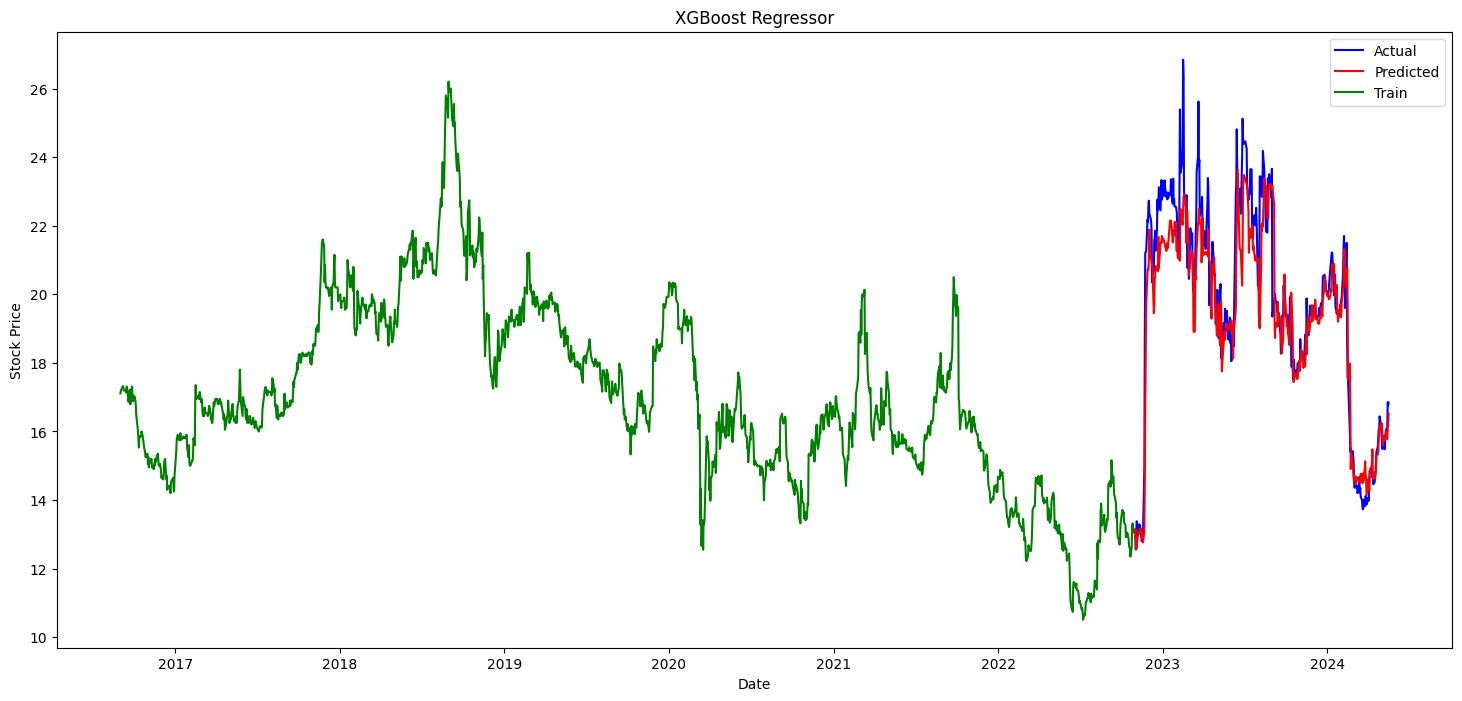

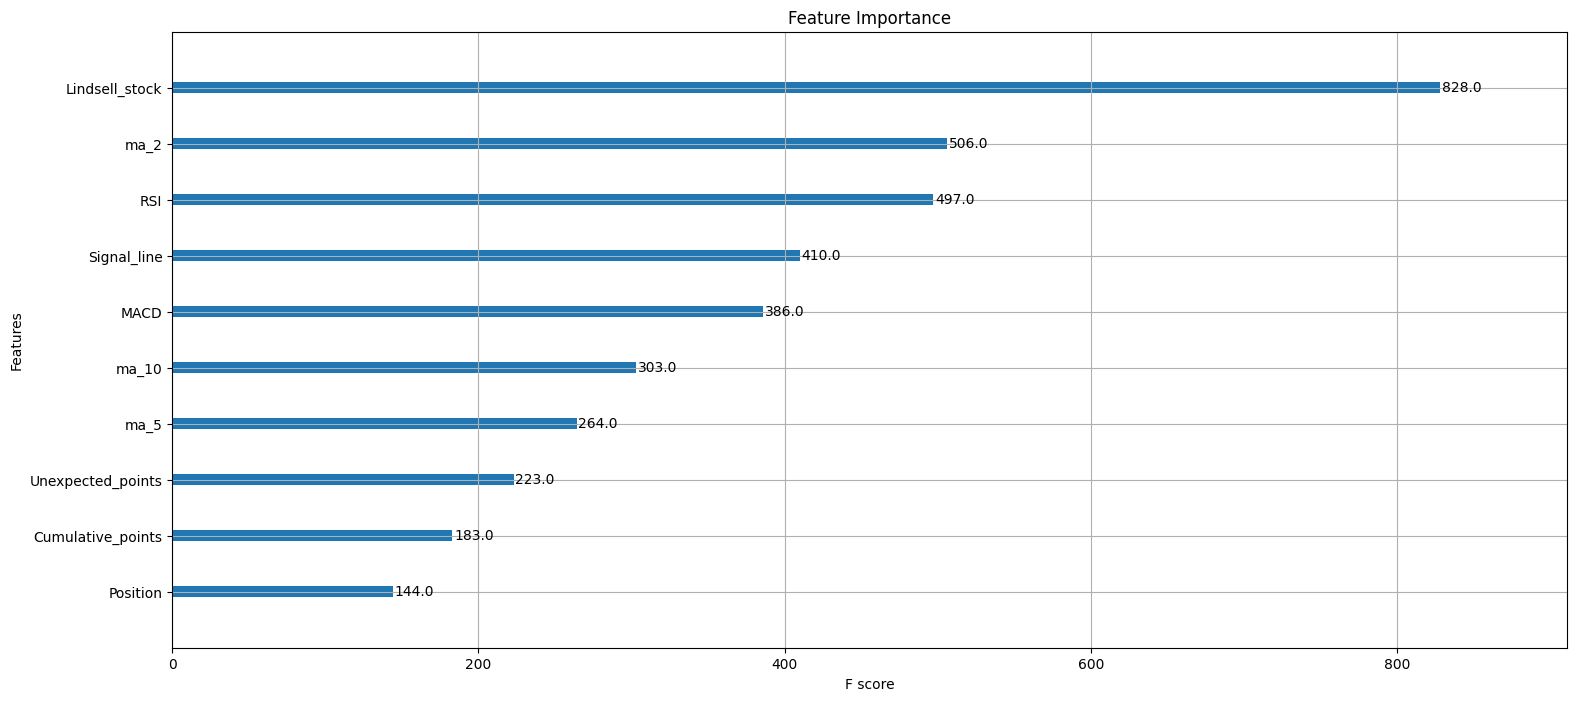

In [34]:
# dropping Points and Interest columns
features = features.drop(['Points', 'Interest'])
X_train, X_test, y_train, y_test, target_scaler = create_train_test(features)
xgb_results = train_and_forecast_XGB(X_train, y_train, X_test, y_test, target_scaler)

# LSTM model

In [18]:
# Import data
df = pd.read_csv('cleaned_data.csv', parse_dates=['Date'], index_col='Date')

target = df['ManU_stock']

df

# train test split
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[:train_size], df.iloc[train_size:]

In [19]:
# Function to create sequences for LSTM
def create_sequences(data, target, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append((data[i:i + seq_length], target[i + seq_length]))
    return sequences

def prepare_data(features_list):
    # Features and target selection
    train_features = train[features_list]
    train_target = train['ManU_stock']
    test_features = test[features_list]
    test_target = test['ManU_stock']

    # Normalize features and target
    scaler_features = StandardScaler().fit(train_features)
    scaler_target = StandardScaler().fit(train_target.values.reshape(-1, 1))

    X_train_scaled = scaler_features.transform(train_features)
    y_train_scaled = scaler_target.transform(train_target.values.reshape(-1, 1))
    X_test_scaled = scaler_features.transform(test_features)
    y_test_scaled = scaler_target.transform(test_target.values.reshape(-1, 1))

    # Set sequence length
    seq_length = 10
    train_sequences = create_sequences(X_train_scaled, y_train_scaled, seq_length)
    test_sequences = create_sequences(X_test_scaled, y_test_scaled, seq_length)

    # Prepare training and testing sets
    X_train, y_train = zip(*train_sequences)
    X_test, y_test = zip(*test_sequences)

    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    return X_train, y_train, X_test, y_test, scaler_target

In [22]:
def train_and_forecast_LSTM(X_train, y_train, X_test, y_test, scaler_target):
    # Build the LSTM model
    model = Sequential()

    # LSTM layers Dropout
    model = Sequential()
    model.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(64, activation='relu', return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), shuffle=False, verbose=0)

    # Plot the training and validation loss
    plt.figure(figsize=(18, 10))
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Make predictions
    test_pred = model.predict(X_test)

    # Inverse transform the predictions
    test_pred_inv = scaler_target.inverse_transform(test_pred)

    # Inverse transform the actual values
    y_test_inv = scaler_target.inverse_transform(y_test.reshape(-1, 1))

    # save the predictions with the actual values and the dates
    results = pd.DataFrame({'Date': test.index[-len(y_test):], 'Actual': y_test_inv.flatten(), 'Predicted': test_pred_inv.flatten()})

    # Calculate the mean absolute error
    mae = mean_absolute_error(y_test_inv, test_pred_inv)
    print('Mean Absolute Error:', mae)

    # Calculate the mean squared error
    mse = mean_squared_error(y_test_inv, test_pred_inv)
    print('Mean Squared Error:', mse)

    # plot the results
    plt.figure(figsize=(18, 10))
    plt.plot(results['Date'], results['Actual'], label='Actual', color='blue', alpha=0.7)
    plt.plot(results['Date'], results['Predicted'], label='Predicted', color='red', alpha=0.9)
    plt.plot(train.index, train['ManU_stock'], label='Train', color='green', alpha=0.7)
    plt.title('ManU Stock Price Prediction')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

    return results

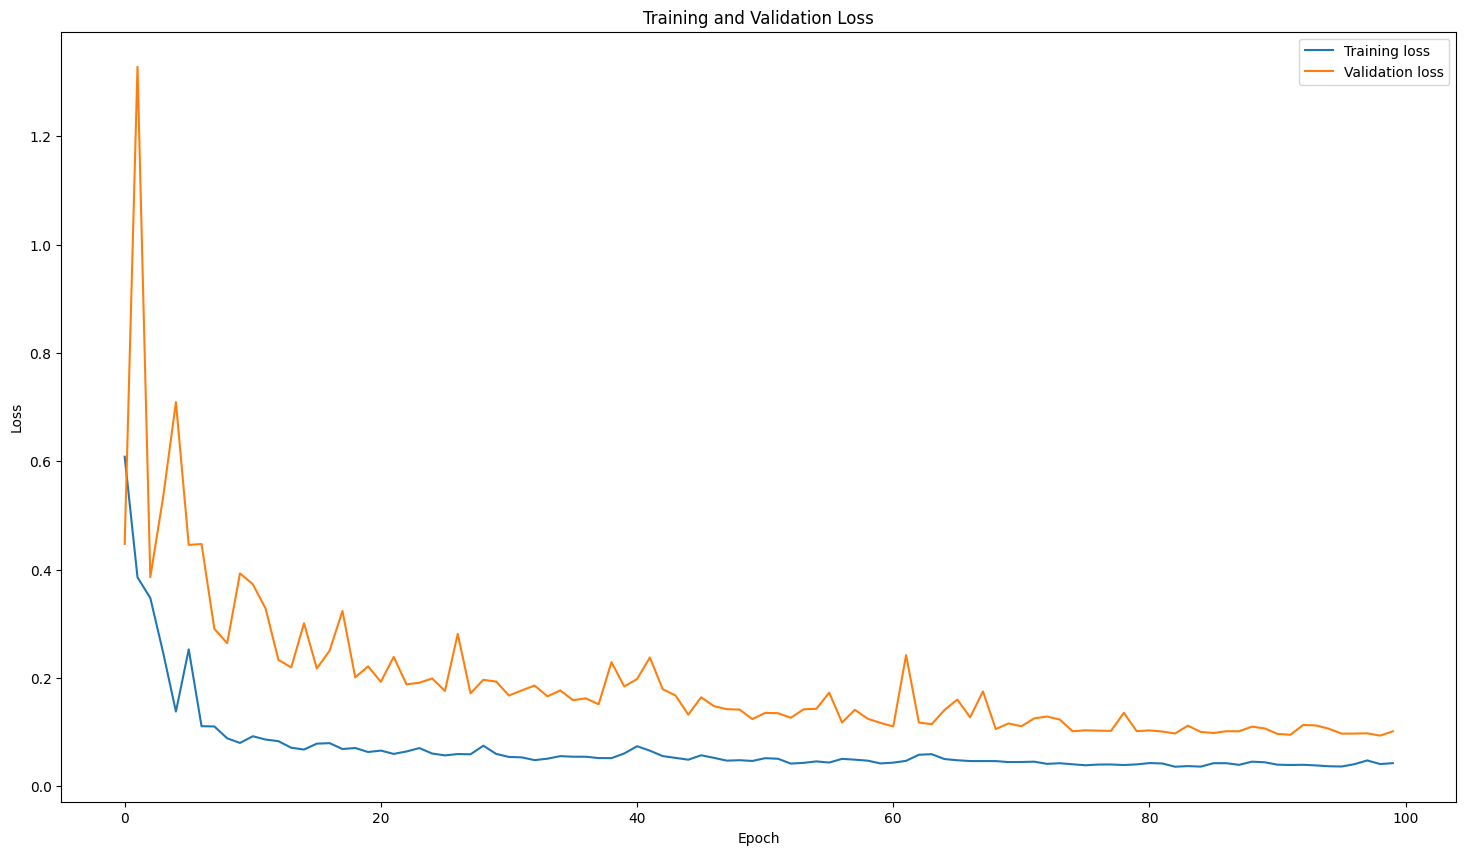

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Mean Absolute Error: 0.5466350320130196
Mean Squared Error: 0.7031998342324003


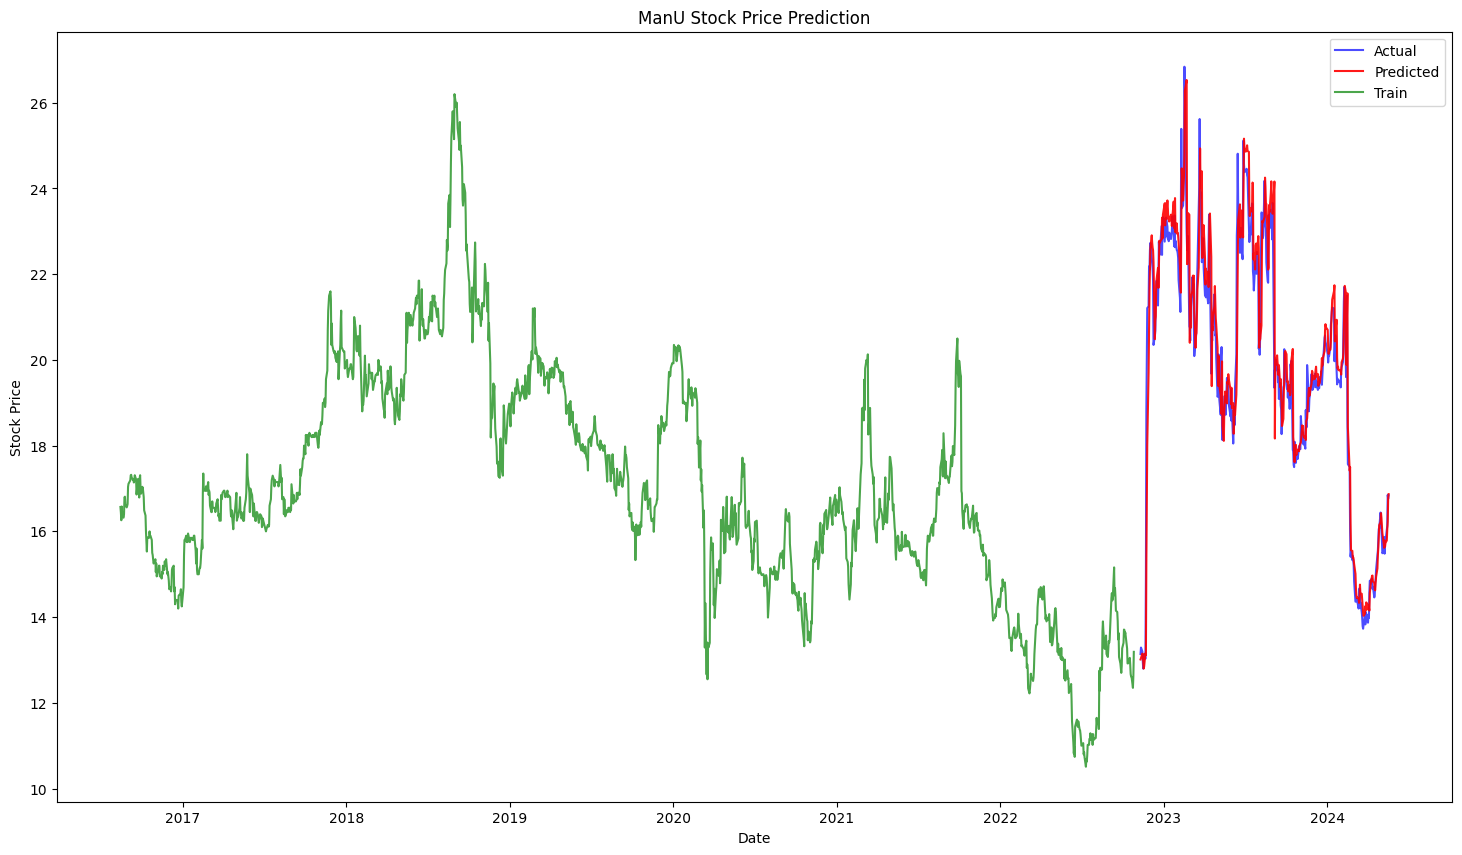

In [23]:
X_train, y_train, X_test, y_test, scaler_target = prepare_data(['ManU_stock', 'Lindsell_stock','Unexpected_points'])
lstm_results = train_and_forecast_LSTM(X_train, y_train, X_test, y_test, scaler_target)

In [35]:
# save the results
lstm_results.to_csv('lstm_results.csv', index=False)
xgb_results.to_csv('xgb_results.csv', index=False)